In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import vectorbt as vbt
import os

import pandas as pd, numpy as np, matplotlib.pyplot as plt, warnings, itertools, random
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import TimeSeriesSplit
from deap import base, creator, tools, algorithms

warnings.filterwarnings("ignore")   # to keep notebook output tidy

In [14]:
import os
import pandas as pd

# Absolute path to the processed CSV file
csv_path = r'c:\Users\Eddy\YTM Capital Dropbox\Eddy Winiarz\Trading\COF\Models\Unfinished Models\Eddy\Python Projects\BT\data_pipelines\data_processed\with_er_daily.csv'

# Debug: Print file path and check existence
print(f"Attempting to load data from: {csv_path}")
if not os.path.isfile(csv_path):
    print(f"ERROR: File not found at {csv_path}. Please check the path and try again.")
    # Optionally, raise an error or handle fallback here
else:
    # Load and process the data
    df = (pd.read_csv(csv_path, parse_dates=['Date'])
            .set_index('Date')
            .resample('W-FRI').last())
    price = df['cad_ig_er_index']
    ret   = price.pct_change()
    # Debug: Show head of dataframe and returns
    print("Loaded data (head):")
    print(df.head())
    print("First few returns:")
    print(ret.head())
    print("Data shape:", df.shape)
    print("Data info:", df.info())

Attempting to load data from: c:\Users\Eddy\YTM Capital Dropbox\Eddy Winiarz\Trading\COF\Models\Unfinished Models\Eddy\Python Projects\BT\data_pipelines\data_processed\with_er_daily.csv
Loaded data (head):
              cad_oas   us_hy_oas  us_ig_oas      tsx    vix  us_3m_10y  \
Date                                                                      
2003-12-05  66.455945  409.127001  96.816591  7990.28  17.09    417.689   
2003-12-12  66.262961  404.251163  98.293708  7979.20  16.41    419.678   
2003-12-19  69.327974  402.622473  96.420352  8113.82  16.42    408.935   
2003-12-26  66.142013  399.150859  96.032625  8136.78  17.45    410.376   
2004-01-02  72.793447  380.452564  93.932615  8293.70  18.22    419.626   

            us_growth_surprises  us_inflation_surprises  us_lei_yoy  \
Date                                                                  
2003-12-05              0.53935                -0.14891         6.3   
2003-12-12              0.53646                -0.13339

Optimal θ=0.43  |  Total return=72.5%


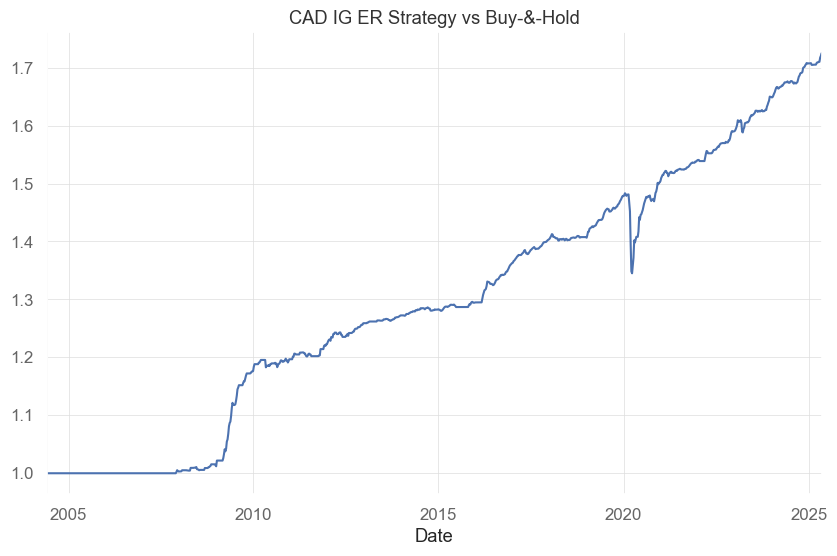

In [15]:

# ---------- 2. Features & label ----------
df['fwd_ret'] = ret.shift(-1)
for lag in (1,4,12,26):
    df[f'mom_{lag}w'] = price.pct_change(lag)
df['vol_4w']  = ret.rolling(4).std()
df['vol_12w'] = ret.rolling(12).std()
df = df.dropna()

X = df[[c for c in df.columns if c.startswith(('mom_','vol_'))]]
y = (df['fwd_ret']>0).astype(int)

# ---------- 3. Walk-forward CV + proba ----------
tscv  = TimeSeriesSplit(n_splits=5)
proba = np.zeros(len(y))
for tr_idx, te_idx in tscv.split(X):
    m = GradientBoostingClassifier()
    m.fit(X.iloc[tr_idx], y.iloc[tr_idx])
    proba[te_idx] = m.predict_proba(X.iloc[te_idx])[:,1]
df['proba'] = proba

# ---------- 4. Threshold optimisation ----------
best_thr, best_ret = None, -np.inf
for thr in np.linspace(0.4,0.8,17):
    s   = (df['proba']>thr).astype(int)
    eq  = (1 + ret.loc[s.index]*s).cumprod()
    tr  = eq.iloc[-1]-1
    if tr > best_ret: best_thr, best_ret = thr, tr
print(f'Optimal θ={best_thr:.2f}  |  Total return={best_ret:.1%}')

# ---------- 5. Final equity curve ----------
signal = (df['proba']>best_thr).astype(int)
equity = (1 + ret.loc[signal.index]*signal).cumprod()
equity.plot(title='CAD IG ER Strategy vs Buy-&-Hold');
